In [1]:
from example_utils import *

# remove all previous experiments
!rm -rf my_experiment 
!rm -rf my-talkative-experiments
!rm -rf linear_regression

# Digital Experiments

## The Basics

At its most basic, a digital experiment is a peice of code that takes some inputs and produces some results.

To keep track of these inputs and results automatically, `digital_experiments` provides the `@experiment` decorator:

In [2]:
from digital_experiments import experiment


@experiment
def my_experiment(a, b, power=2):
    return (a - b) ** power + a

Running an experiment and recording the output is as simple as calling the function:

In [3]:
my_experiment(1, 2)

Starting new experiment - 221021-115458-4914-that-wear
Arguments: {
    "a": 1,
    "b": 2,
    "power": 2
}
Finished experiment - 221021-115458-4914-that-wear



2

We can see that digital_experiments logs that an experiment has occurred, together with the arguments used to run it (including defaults from the function that we didn't pass!)

By default, a folder to hold all of these experiments is created with the name of the function (in this case `my_experiment`). 

Each call of the function corresponds to a single experiment. These are named with the timestep at which they were started (so that they appear in chronological order within file systems) together with a human readable identifier, and appear as sub-folders:

In [4]:
!find my_experiment

my_experiment
my_experiment/221021-115458-4914-that-wear
my_experiment/221021-115458-4914-that-wear/config.json
my_experiment/221021-115458-4914-that-wear/results.json
my_experiment/221021-115458-4914-that-wear/metadata.json
my_experiment/221021-115458-4914-that-wear/log


Under-the-hood, `digital_experiments` has saved everything we want to know about this experiment!

We can inspect experiment files directly from the file system:

In [5]:
!cat my_experiment/*/config.json

{
    "a": 1,
    "b": 2,
    "power": 2
}

... and also access them from within python:

In [6]:
from digital_experiments import all_experiments_matching

df, experiments = all_experiments_matching("my_experiment")

In [7]:
# df is a pandas dataframe containing the configurations and results
# of all experiments (together with their running time in seconds)
df

,experiment_number,a,b,power,result,run_duration
0,0,1,2,2,2,0.000206


In [8]:
# experiments is a list of Experiment objects, indexed by experiment_number
experiments[0].config

{'a': 1, 'b': 2, 'power': 2}

In [9]:
experiments[0].result

2

## Advanced Usage

### Logging and Verbosity

The experiment decorator can take several keyword arguments:
- `save_to` specifies the folder to save all experiments to (defaults to the name of the function)
- `capture_logs` - if this is set to True, anything printed from within the experiment is saved to `log`
- `verbose` - controls whether `digital_experiments` prints additional information about each experiment

In [10]:
# i.e. capture logs, but don't print out digita_experiment messages
@experiment(save_to="my-talkative-experiments", verbose=False)
def talkative_experiment(a, b, power=2):
    print("Hello!")
    return (a - b) ** power + a

talkative_experiment(1, 2)

Hello!


2

In [11]:
!cat my-talkative-experiments/*/log

Hello!


In [12]:
_, experiments = all_experiments_matching("my-talkative-experiments")
experiments[0].log

'Hello!\n'

### Multiple Results and Artefacts

It is often the case that we have more than a single result.
`digital_experiments` can handle these intelligently when they are returned as an (optionally nested) dict.

Artefacts can be automatically be saved in the correct folder using the `current_directory` function:

In [13]:
import pickle
import numpy as np
from sklearn.linear_model import Ridge
from digital_experiments import current_directory


X = np.random.rand(100, 3) * 20
y = X[:,0] * 2 + X[:,1] * 4 + 2 + np.random.randn(100) * 5


@experiment(verbose=False)
def linear_regression(alpha, fit_intercept=True):
    model = Ridge(alpha, fit_intercept=fit_intercept)
    train, test = slice(0, 10), slice(90, 100)

    model.fit(X[train], y[train])
    yhat = model.predict(X)
    errors = yhat - y

    with open(current_directory() / "model.pkl", "wb") as f:
        pickle.dump(model, f)

    return {
        "mae": {
            name: np.abs(errors[split]).mean()
            for name, split in zip(["train", "test"], [train, test])
        },
        "rmse": {
            name: (errors[split] ** 2).mean() ** 0.5
            for name, split in zip(["train", "test"], [train, test])
        }
    }


linear_regression(alpha=0.1)

{'mae': {'train': 3.880204200094835, 'test': 3.8248210136530894},
 'rmse': {'train': 4.41491806942661, 'test': 4.690840163950281}}

In [14]:
for alpha in range(10):
    linear_regression(alpha * 10)

Nested results are flattened using ".":

In [21]:
df, experiments = all_experiments_matching("linear_regression")
df.head()

,experiment_number,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test,run_duration
0,0,0.1,True,3.880204,3.824821,4.414918,4.690840,0.002139
1,1,0.0,True,3.881955,3.829845,4.414905,4.698168,0.000672
2,2,10.0,True,3.759434,3.365338,4.530320,4.070843,0.001372
3,3,20.0,True,3.853732,2.965832,4.818349,3.661490,0.000426
4,4,30.0,True,4.198785,2.709165,5.206721,3.472825,0.000617


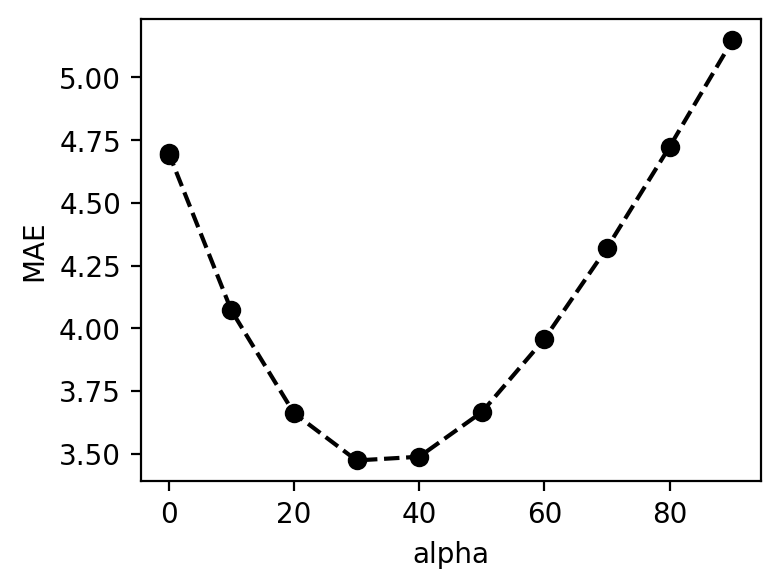

In [16]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(4, 3))
plt.plot(df.alpha, df['rmse.test'], "--ko")
plt.xlabel("alpha")
plt.ylabel("MAE");

Artefacts saved during an experiment can be accessed using `.artefacts`: a mapping of filename to actual path.

In [22]:
experiments[0].artefacts

{'model.pkl': PosixPath('linear_regression/221021-115459-7600-vain-help/model.pkl')}

### Template Matching

When accessing experiments, we can filter them based on their config:

In [18]:
def filter(**template):
    df, _ = all_experiments_matching("linear_regression", template)
    return df

In [19]:
# exact matches
filter(alpha=0)

,experiment_number,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test,run_duration
0,0,0,True,3.881955,3.829845,4.414905,4.698168,0.000672


In [20]:
# function
filter(alpha=lambda x: x >= 20)

,experiment_number,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test,run_duration
0,0,20,True,3.853732,2.965832,4.818349,3.661490,0.000426
1,1,30,True,4.198785,2.709165,5.206721,3.472825,0.000617
2,2,40,True,4.552280,2.710215,5.646378,3.487600,0.000362
3,3,50,True,4.973246,2.755630,6.107214,3.665605,0.000659
4,4,60,True,5.354879,2.871210,6.571638,3.957766,0.000365
5,5,70,True,5.754096,3.219142,7.029657,4.321155,0.000319
6,6,80,True,6.192353,3.654612,7.475758,4.724593,0.000755
7,7,90,True,6.601797,4.133839,7.907054,5.147491,0.000473
